In [2]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [10]:
main_dir='/cloud/skogsstyrelsen_1c/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [59]:
dir_index=-1
directory=directories[dir_index]

In [60]:

bounds=[]
temporals_t=glob.glob(main_dir+directory+'/*.nc')
temporals=[]
for t in temporals_t:
    temporals.append(t.split('/')[-1].split('.')[0])

In [61]:
len(temporals)

28

In [62]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

In [63]:
import xarray as xr

/home/edgelab/.local/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


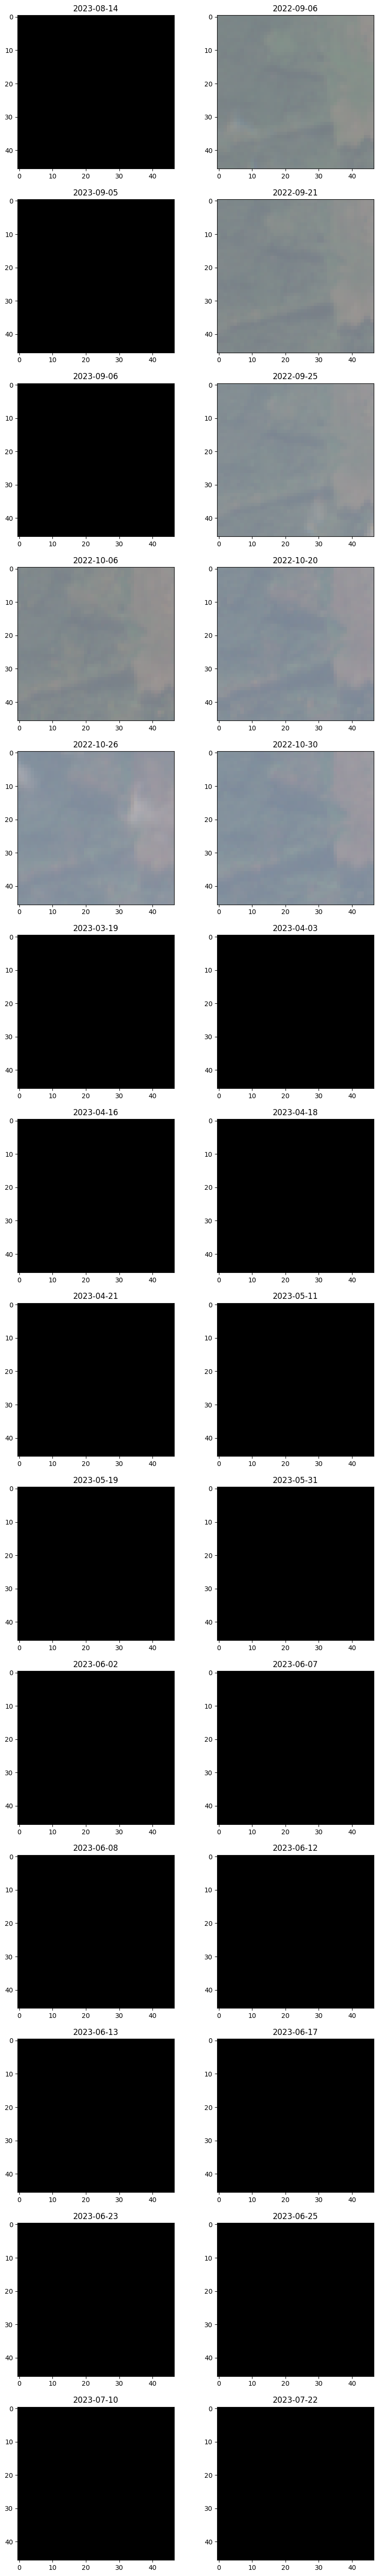

In [68]:
ncols=2
nrows=int(np.ceil(len(temporals)/ncols))

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    loaded_data = xr.open_dataset(main_dir+directory+'/'+temporals[i]+'.nc', engine='netcdf4', decode_times=True)
    variables=loaded_data.variables

    b04=variables['b04'].data[0]
    b03=variables['b03'].data[0]
    b02=variables['b02'].data[0]

    b04T=sAdj(b04/10000-ray['r'])
    b03T=sAdj(b03/10000-ray['g'])
    b02T=sAdj(b02/10000-ray['b'])

    rgbLin=satEnh(b04T,b03T,b02T)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)
                
    b04T=rgbLin[0]
    b03T=rgbLin[1]
    b02T=rgbLin[2]

    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im[:,:,0]=b04T
    im[:,:,1]=b03T
    im[:,:,2]=b02T

    ax.imshow(im)#/np.max(im,axis=(0,1)))
    ax.set_title(temporals[i])
    